# Learning Theory from First Principles

## Chapter 3 : Linear least-squares regression

### Generic packages, settings and helper functions



#### Packages

In [ ]:
from google.colab import files
import numpy as np
from numpy.random import randn, rand
from numpy.linalg import svd, norm
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
from scipy.stats import ortho_group
from scipy.special import erfinv, gamma
from scipy.linalg import sqrtm, eigh
from bisect import bisect
import tqdm
import warnings

np.random.seed(seed=1)

#### Settings

The code below is used to standardize the appearance of the graphics. The graphs may appear unevenly sized when displayed in this notebook, but once downloaded they are the correct size.

In [ ]:
# Appearance of the graphs

# adujst font
SMALL_FONT = 5
MED_FONT = 8
BIG_FONT = 12
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = SMALL_FONT
mpl.rcParams['axes.titlesize'] = SMALL_FONT

# adujst lines and markers
mpl.rcParams['axes.linewidth'] = .3
mpl.rcParams['lines.linewidth'] = .7
mpl.rcParams['lines.markersize'] = 2
mpl.rcParams['patch.linewidth'] = .3
mpl.rcParams['errorbar.capsize'] = 1.5
mpl.rcParams['lines.markeredgewidth'] = .3

# withdraw the ticks
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['ytick.left'] = False
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0

# adjust legend box
mpl.rcParams['legend.fancybox'] = 0
mpl.rcParams['legend.shadow'] = 0
mpl.rcParams['legend.framealpha'] = 1

# adjust fig general settings
mpl.rcParams['figure.dpi'] = 600

big_rectangle = (6.5, 3.5) # height = 9 cm, width = 17 cm
medium_rectangle = (4.7, 1.6) # height = 4 cm, width = 12 cm
medium_square = (4.7, 4.7) # height = 12 cm, width = 12 cm
small_rectangle = (2.4, 1.6) # height = 6 cm, width = 4 cm
mpl.rcParams['figure.figsize'] = small_rectangle

inner_space = {'wspace':.5, 'hspace':.5}

# savefig params
mpl.rcParams["savefig.bbox"] = 'tight'

#### Helper functions

In [ ]:
def mse(y_hat, y):
  return np.mean((y - y_hat)**2)

zero_one = np.vectorize(lambda u: 1 if u<0 else 0)
hinge = np.vectorize(lambda u: np.maximum(1-u, 0))
square = np.vectorize(lambda u: (1-u)**2)
logis = np.vectorize(lambda u: np.log(1+np.exp(-u)))

### Figures

#### Figure 3.1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

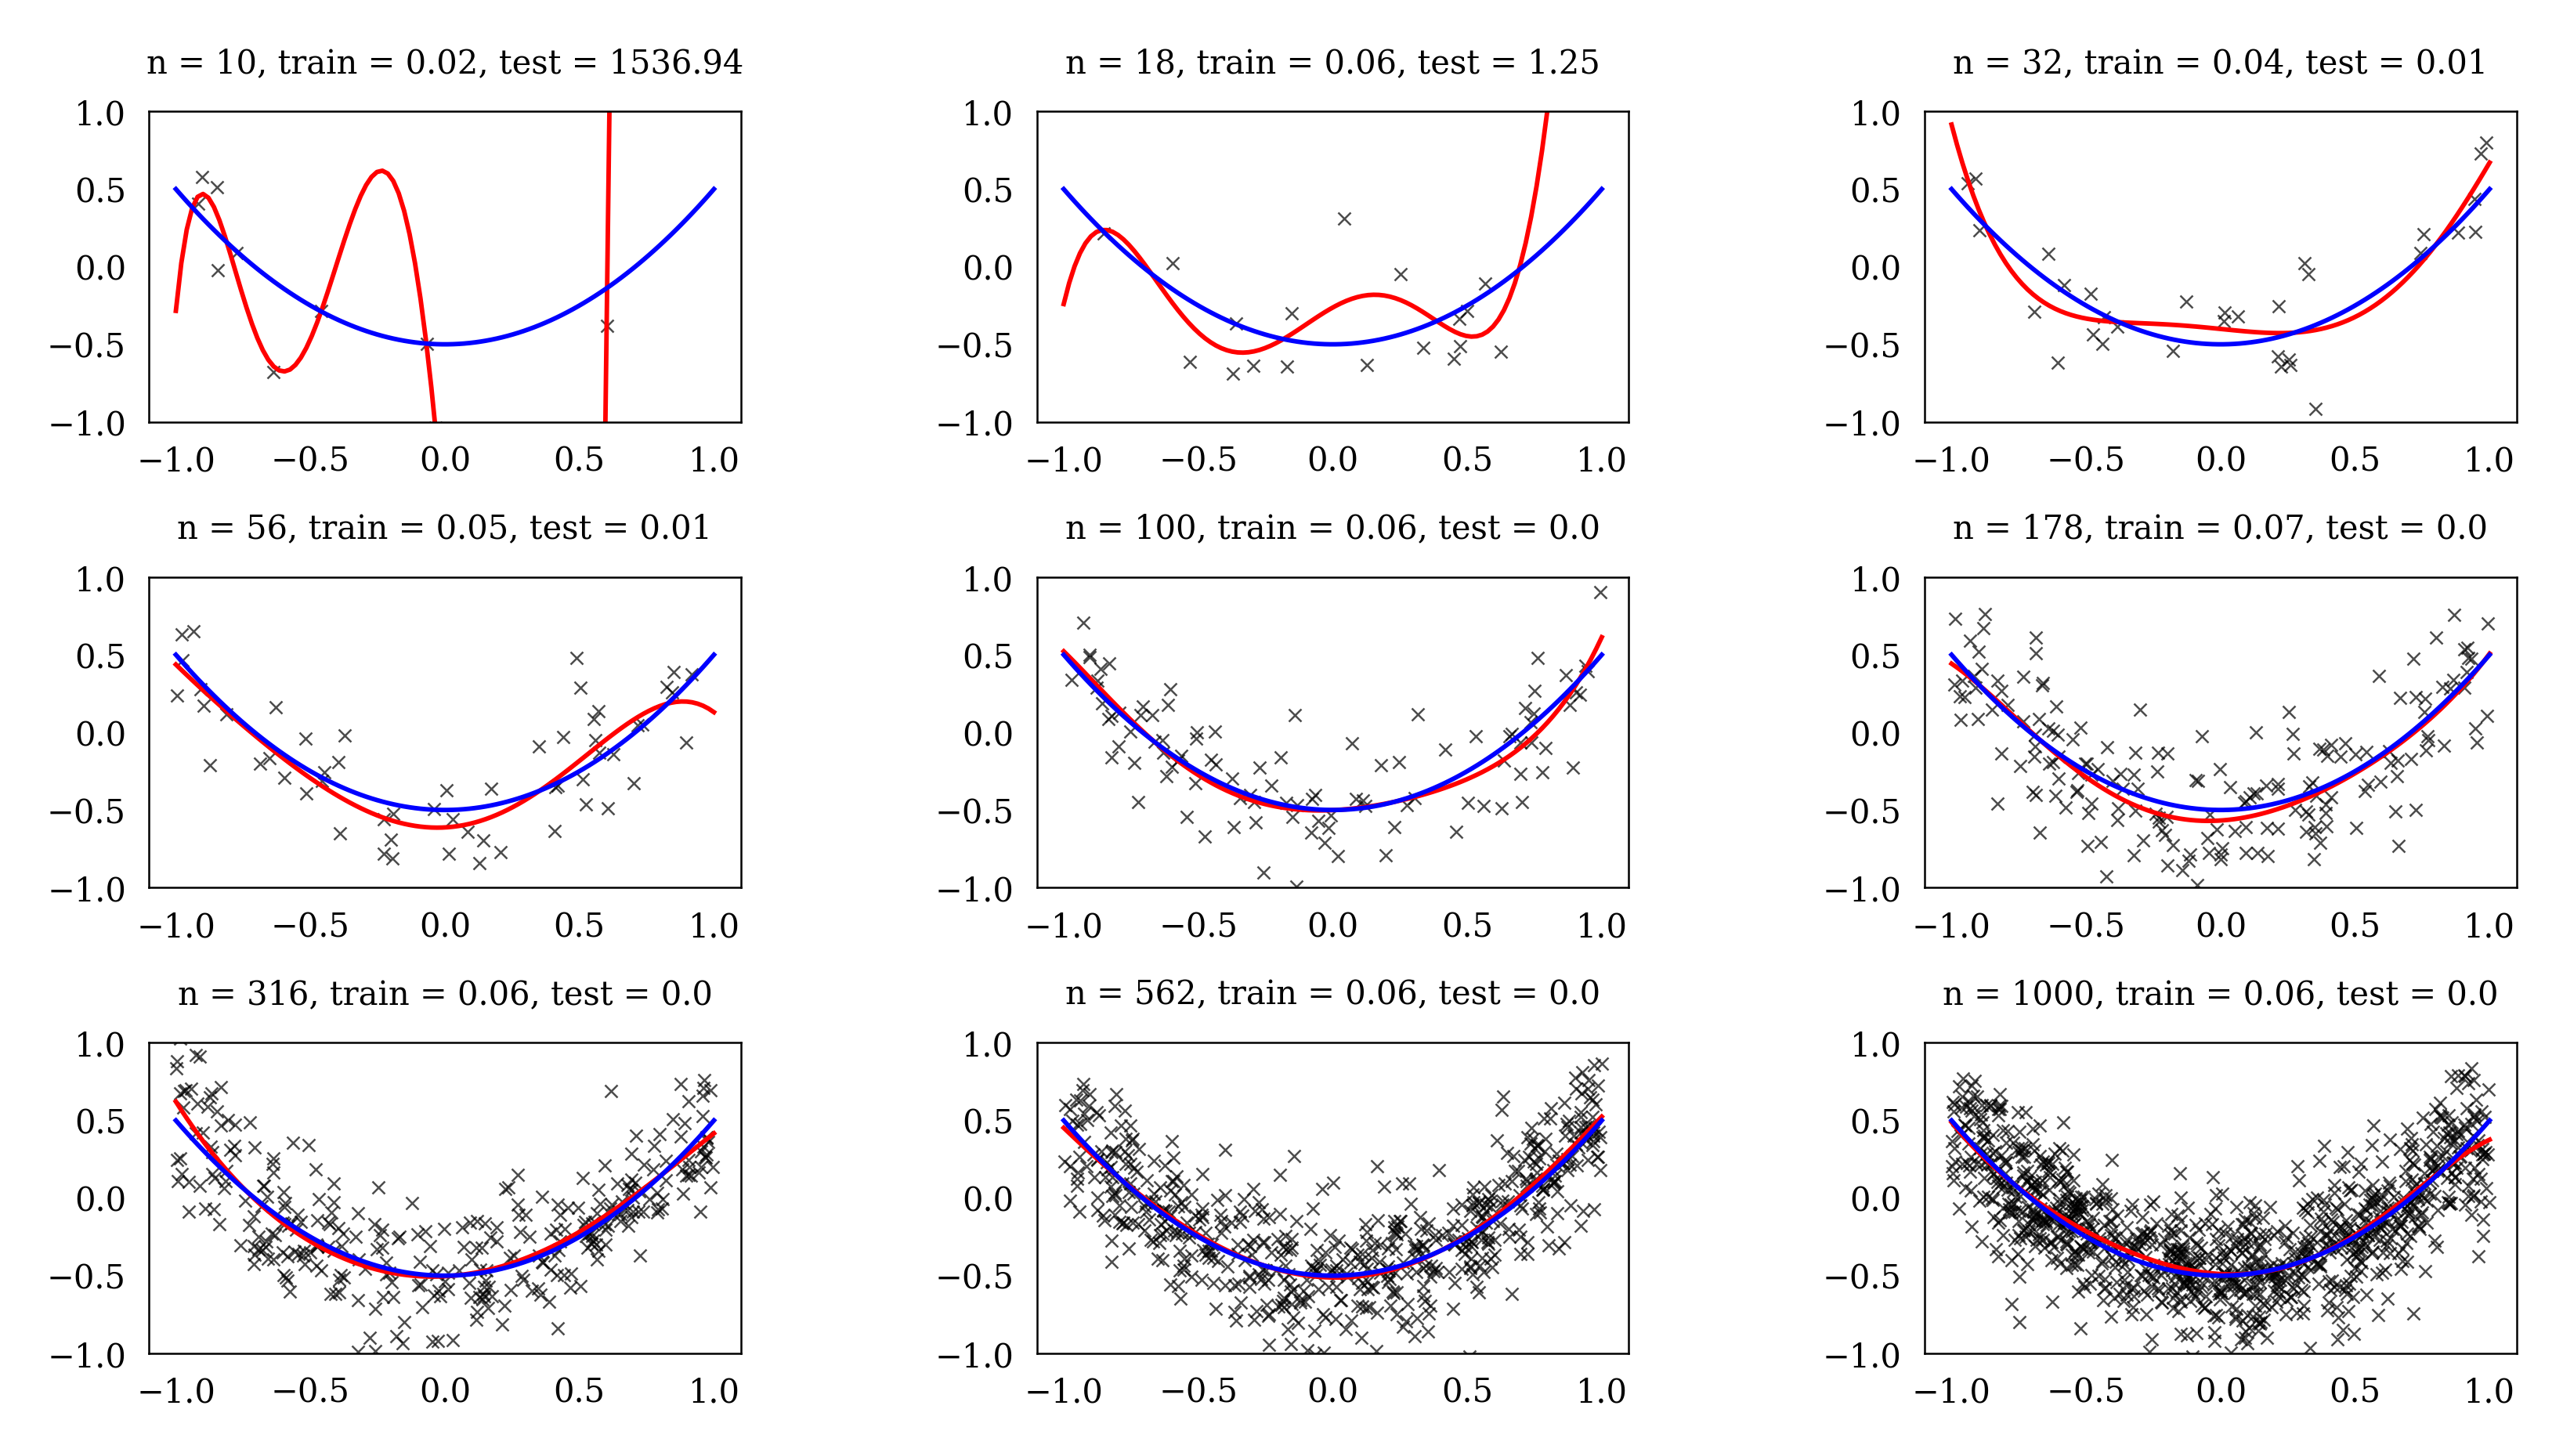

In [ ]:
# fig settings
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=big_rectangle, gridspec_kw = inner_space)

#constants
x_axis = np.linspace(-1, 1, 100)
y_axis = x_axis**2 - 0.5
k = 5
n = [10,18,32,56,100,178,316,562,1000]

for i, ax in zip(n,  axs.ravel()):
    #samples
    x = np.sort(np.random.uniform(-1, 1, i))
    y = - 0.5 + x**2 + np.random.normal(scale = 0.25, size=i)

    # format data
    X = x.reshape(-1, 1)
    X_polynom = np.hstack([X**i for i in range(5, -1, -1)])
    x_axis_reshaped = x_axis.reshape(-1, 1)
    x_axis_polynom = np.hstack([x_axis_reshaped**i for i in range(5, -1, -1)])

    #train model
    lin_reg = LinearRegression()
    lin_reg.fit(X_polynom,y)
    coef = np.hstack([lin_reg.coef_[0:-1], lin_reg.intercept_])

    # plot
    ax.set_ylim([-1, 1])
    plt.sca(ax)
    plt.plot(x, y, 'xk', alpha=0.7)
    line = plt.plot(x_axis, np.polyval(coef, x_axis), color='r')
    plt.plot(x_axis, y_axis, color='b')
    plt.title('n = ' + str(i) +
              ', train = ' + str(round(mse(lin_reg.predict(X_polynom), y),2)) +
              ', test = ' + str(round(mse(lin_reg.predict(x_axis_polynom), y_axis),2)))

plt.savefig('fig31.svg')
files.download("fig31.svg")

plt.show()

#### Figure 3.2



```
addpath ..


clear all
seed=1;
randn('state',seed);
rand('state',seed);
std_noise = .25;

Xgrid = (-1:.001:1)';
ns = round(10.^[1:.25:5]);
Ygrid = Xgrid.^2 - .5;
Ygrid_with_noise = Xgrid.^2 - .5 + randn(length(Ygrid),1) * std_noise;
nrep = 32;
for irep=1:nrep
    for in=1:length(ns)
        n = ns(in);
        
        Xsample = rand(n,1)*2-1;
        Ysample = Xsample.^2 - .5 + randn(n,1) * std_noise;
        
        
        
        kmax = 5;
        Xdata = ones(n,1);
        Xgriddata = ones(length(Xgrid),1);
        
        for i=0:kmax
            wdata = (Xdata' * Xdata) \ ( Xdata' * Ysample);
            Ygrid_prediction = Xgriddata * wdata;
            train_error(irep,in) = mean((Xdata*wdata-Ysample).^2);
            insample_error(irep,in) = mean((Xdata*wdata-( Xsample.^2 - .5)).^2);
            test_error(irep,in) = std_noise^2+mean((Ygrid_prediction-Ygrid).^2);
            
            if i<kmax
                Xdata = [ Xdata, Xsample.^(i+1) ];
                Xgriddata = [ Xgriddata, Xgrid.^(i+1) ];
            end
        end
    end
end

try
    ccc=openfig('polynomial_regression_varying_n_rate.fig');
catch
    disp('missing figure file')
end

subplot(1,2,1);
errorbar(log10(ns),log10(mean(insample_error,1) ),log10(mean(insample_error,1) - std(insample_error,1)  )-log10(mean(insample_error,1)),log10(mean(insample_error,1) + std(insample_error,1)  )-log10(mean(insample_error,1)),'b','linewidth',2); hold on;
plot(log10(ns),log10(std_noise.^2 * (kmax+1)./ns),'r','linewidth',2); hold off;
set(gca,'fontsize',16)
xlabel('log_{10}(n)')
ylabel('log_{10}(excess risk)')
legend('excess risk','\sigma^2 d / n');
title('Fixed design','FontWeight','normal')
axis([1 5 -6 4])


subplot(1,2,2);
errorbar(log10(ns),log10(mean(test_error,1)-std_noise.^2),log10(max(mean(test_error,1)-std(test_error,1)-std_noise.^2,1e-12))-log10(mean(test_error,1)-std_noise.^2),log10(mean(test_error,1)+std(test_error,1)-std_noise.^2)-log10(mean(test_error,1)-std_noise.^2) ,'b','linewidth',2); hold on;
plot(log10(ns),log10(std_noise.^2 * (kmax+1)./ns),'r','linewidth',2); hold off;
set(gca,'fontsize',16)
xlabel('log_{10}(n)')
ylabel('log_{10}(excess risk)')
legend('excess risk','\sigma^2 d / n');
title('Random design','FontWeight','normal')
axis([1 5 -6 4])

try
    print('-depsc', 'polynomial_regression_varying_n_rate.eps');
    close(ccc)
catch
    disp('missing figure file')
end

```



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

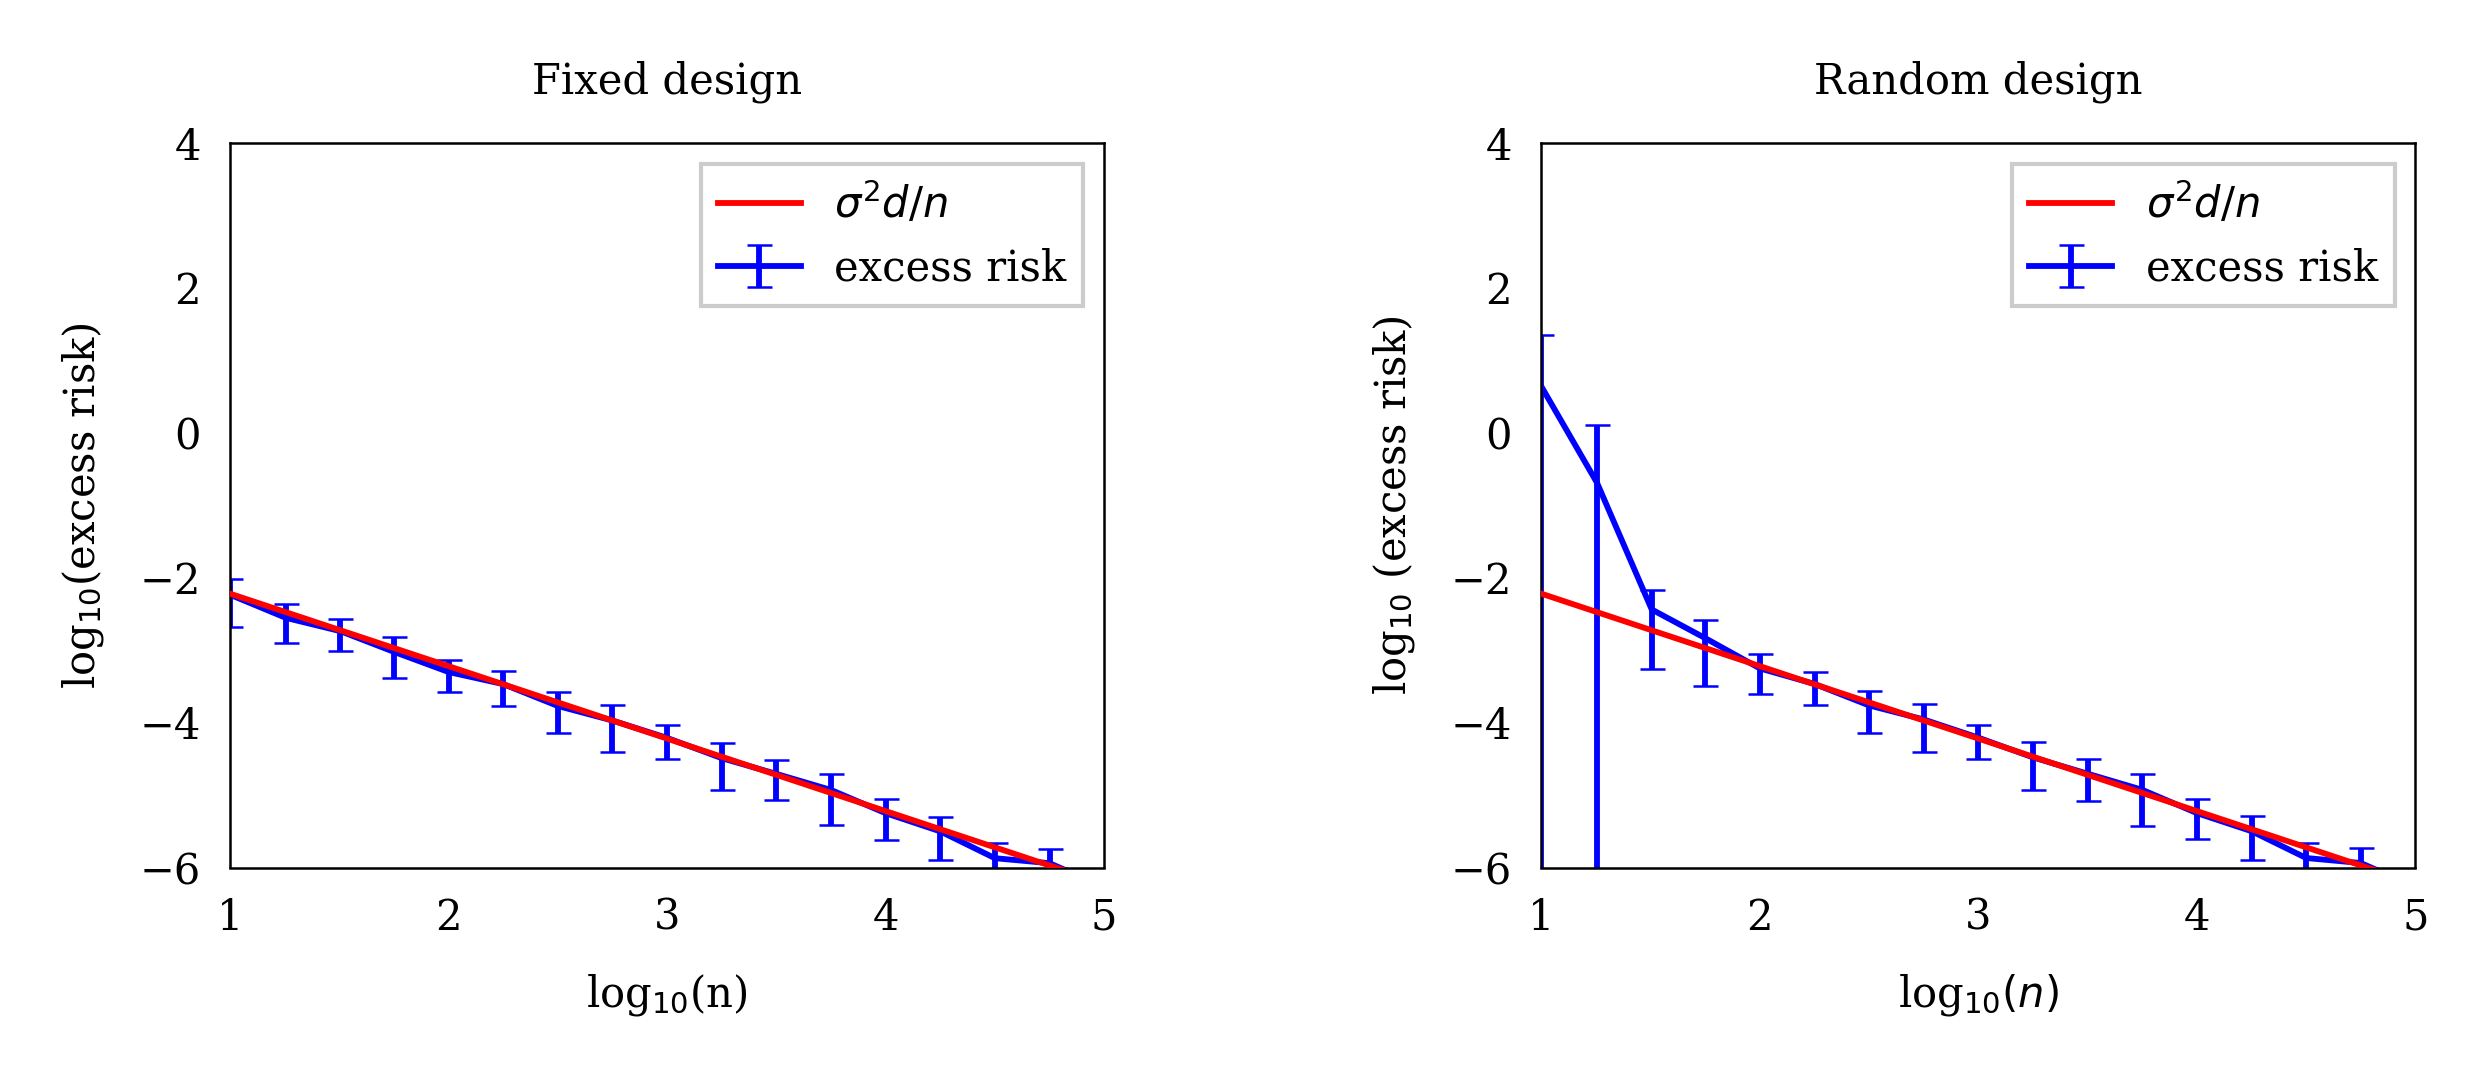

In [ ]:
Xgrid = np.linspace(-1, 1, 1001)
ns = np.round(10**np.arange(1, 5.25, 0.25))
Ygrid = Xgrid**2 - 0.5
std_noise = 0.1
Ygrid_with_noise = Xgrid**2 - 0.5 + np.random.randn(len(Ygrid)) * std_noise
nrep = 32

train_error = np.zeros((nrep, len(ns)))
insample_error = np.zeros((nrep, len(ns)))
test_error = np.zeros((nrep, len(ns)))

for irep in range(nrep):
    for in_, n in enumerate(ns):
        Xsample = (np.random.rand(int(n)) * 2) - 1
        Ysample = Xsample**2 - 0.5 + np.random.randn(int(n)) * std_noise

        kmax = 5
        Xdata = np.ones((int(n), 1))
        Xgriddata = np.ones((len(Xgrid), 1))

        for i in range(kmax+1):
            wdata = np.linalg.inv(Xdata.T @ Xdata) @ (Xdata.T @ Ysample)
            Ygrid_prediction = Xgriddata @ wdata
            train_error[irep, in_] = np.mean((Xdata @ wdata - Ysample)**2)
            insample_error[irep, in_] = np.mean((Xdata @ wdata - (Xsample**2 - 0.5))**2)
            test_error[irep, in_] = std_noise**2 + np.mean((Ygrid_prediction - Ygrid)**2)

            if i < kmax:
                Xdata = np.hstack((Xdata, Xsample[:, np.newaxis]**(i+1)))
                Xgriddata = np.hstack((Xgriddata, Xgrid[:, np.newaxis]**(i+1)))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=medium_rectangle, gridspec_kw = inner_space)

ax1.errorbar(np.log10(ns),
             np.log10(np.mean(insample_error, axis=0)),
             yerr=np.vstack((np.abs(np.log10(np.mean(insample_error, axis=0) - np.std(insample_error, axis=0)) - np.log10(np.mean(insample_error, axis=0))),
                            np.log10(np.mean(insample_error, axis=0) + np.std(insample_error, axis=0)) - np.log10(np.mean(insample_error, axis=0)) )),
             fmt='b')
ax1.plot(np.log10(ns), np.log10(np.power(std_noise, 2) * (kmax + 1) / ns), 'r', zorder=15)
ax1.set_xlabel('log$_{10}$(n)')
ax1.set_ylabel('log$_{10}$(excess risk)')
ax1.legend(['$\sigma^2 d / n$', 'excess risk'])
ax1.set_title('Fixed design')
ax1.set_xlim([1, 5])
ax1.set_ylim([-6, 4])

ax2.errorbar(np.log10(ns),
             np.log10(np.mean(test_error, axis=0) - np.power(std_noise, 2)),
             yerr=np.vstack((
                np.abs(np.log10(np.maximum(np.mean(test_error, axis=0) - np.std(test_error, axis=0) - np.power(std_noise, 2), 1e-12)) - np.log10(np.mean(test_error, axis=0) - np.power(std_noise, 2))),
                np.log10(np.mean(test_error, axis=0) + np.std(test_error, axis=0) - np.power(std_noise, 2)) - np.log10(np.mean(test_error, axis=0) - np.power(std_noise, 2))
                 )),
             fmt='b')
ax2.plot(np.log10(ns), np.log10(np.power(std_noise, 2) * (kmax + 1) / ns), 'r', zorder=15)
ax2.set_xlabel('log$_{10}(n)$')
ax2.set_ylabel('log$_{10}$ (excess risk)')
ax2.legend(['$\sigma^2 d / n$', 'excess risk'])
ax2.set_title('Random design')
ax2.set_xlim([1, 5])
ax2.set_ylim([-6, 4])

plt.savefig('fig32.svg')
files.download("fig32.svg")

plt.show()


#### Figure 3.3



```
addpath ..

clear all
seed=1;
randn('state',seed);
rand('state',seed);
std_noise = 1;

try
    ccc=openfig('polynomial_regression_ridge.fig');
catch
    disp('missing figure file')
end


Xgrid = (-1:.001:1)';
n = 300;
lambdas = 10.^[-6:.25:2];
Ygrid = Xgrid.^2 - .5;
Ygrid_with_noise = Xgrid.^2 - .5 + randn(length(Ygrid),1) * std_noise;
nrep = 32;
for irep=1:nrep
    
    
    Xsample = rand(n,1)*2-1;
    Ysample = Xsample.^2 - .5 + randn(n,1) * std_noise;
    
    
    
    kmax = 5;
    Xdata = ones(n,1);
    Xgriddata = ones(length(Xgrid),1);
    
    for i=0:kmax
        if i<kmax
            Xdata = [ Xdata, Xsample.^(i+1) ];
            Xgriddata = [ Xgriddata, Xgrid.^(i+1) ];
        end
    end
    
    for ilambda = 1:length(lambdas)
        lambda= lambdas(ilambda);
        w = (Xdata' * Xdata + n* lambda * eye(size(Xdata,2))) \ ( Xdata' * Ysample);
        Ygrid_prediction = Xgriddata * w;
        excess_test_error(irep,ilambda) =  mean((Ygrid_prediction-Ygrid).^2);
    end
end

wast = (Xgriddata' * Xgriddata ) \ ( Xgriddata' * Ygrid);
bias = lambdas;
variance = lambdas;
Sigma = Xdata' * Xdata / n;

for ilambda = 1:length(lambdas)
    lambda= lambdas(ilambda);
    
    bias(ilambda) = lambda^2 * wast'* ( Sigma * inv(Xdata' * Xdata/n +   lambda * eye(size(Xdata,2)))^2 ) * wast;
    variance(ilambda) = std_noise.^2 / n * trace( Sigma^2 * inv(Xdata' * Xdata/n +   lambda * eye(size(Xdata,2)))^2);
    
end
errorbar(log10(lambdas),log10(mean(excess_test_error,1)),log10(mean(excess_test_error,1)+std(excess_test_error,1))-log10(mean(excess_test_error,1)),log10(mean(excess_test_error,1)+std(excess_test_error,1))-log10(mean(excess_test_error,1)),'b','linewidth',2); hold on;
plot(log10(lambdas),log10(bias ),'g','linewidth',2);
plot(log10(lambdas),log10( variance),'k','linewidth',2);
plot(log10(lambdas),log10(bias + variance),'r','linewidth',2); hold off;
set(gca,'fontsize',24)
xlabel('log_{10}(\lambda)')
ylabel('log_{10}(excess risk)')
legend('estimated excess risk','theoretical bias','theoretical variance','bias+variance','location','NorthEastOutside');
title('polynomial regression (dim = 5) - Ridge','FontWeight','normal')

axis([min(log10(lambdas)) max(log10(lambdas)) -5 -1])

try
    print('-depsc', 'polynomial_regression_ridge.eps');
    close(ccc)
catch
    disp('missing figure file')
end
```



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

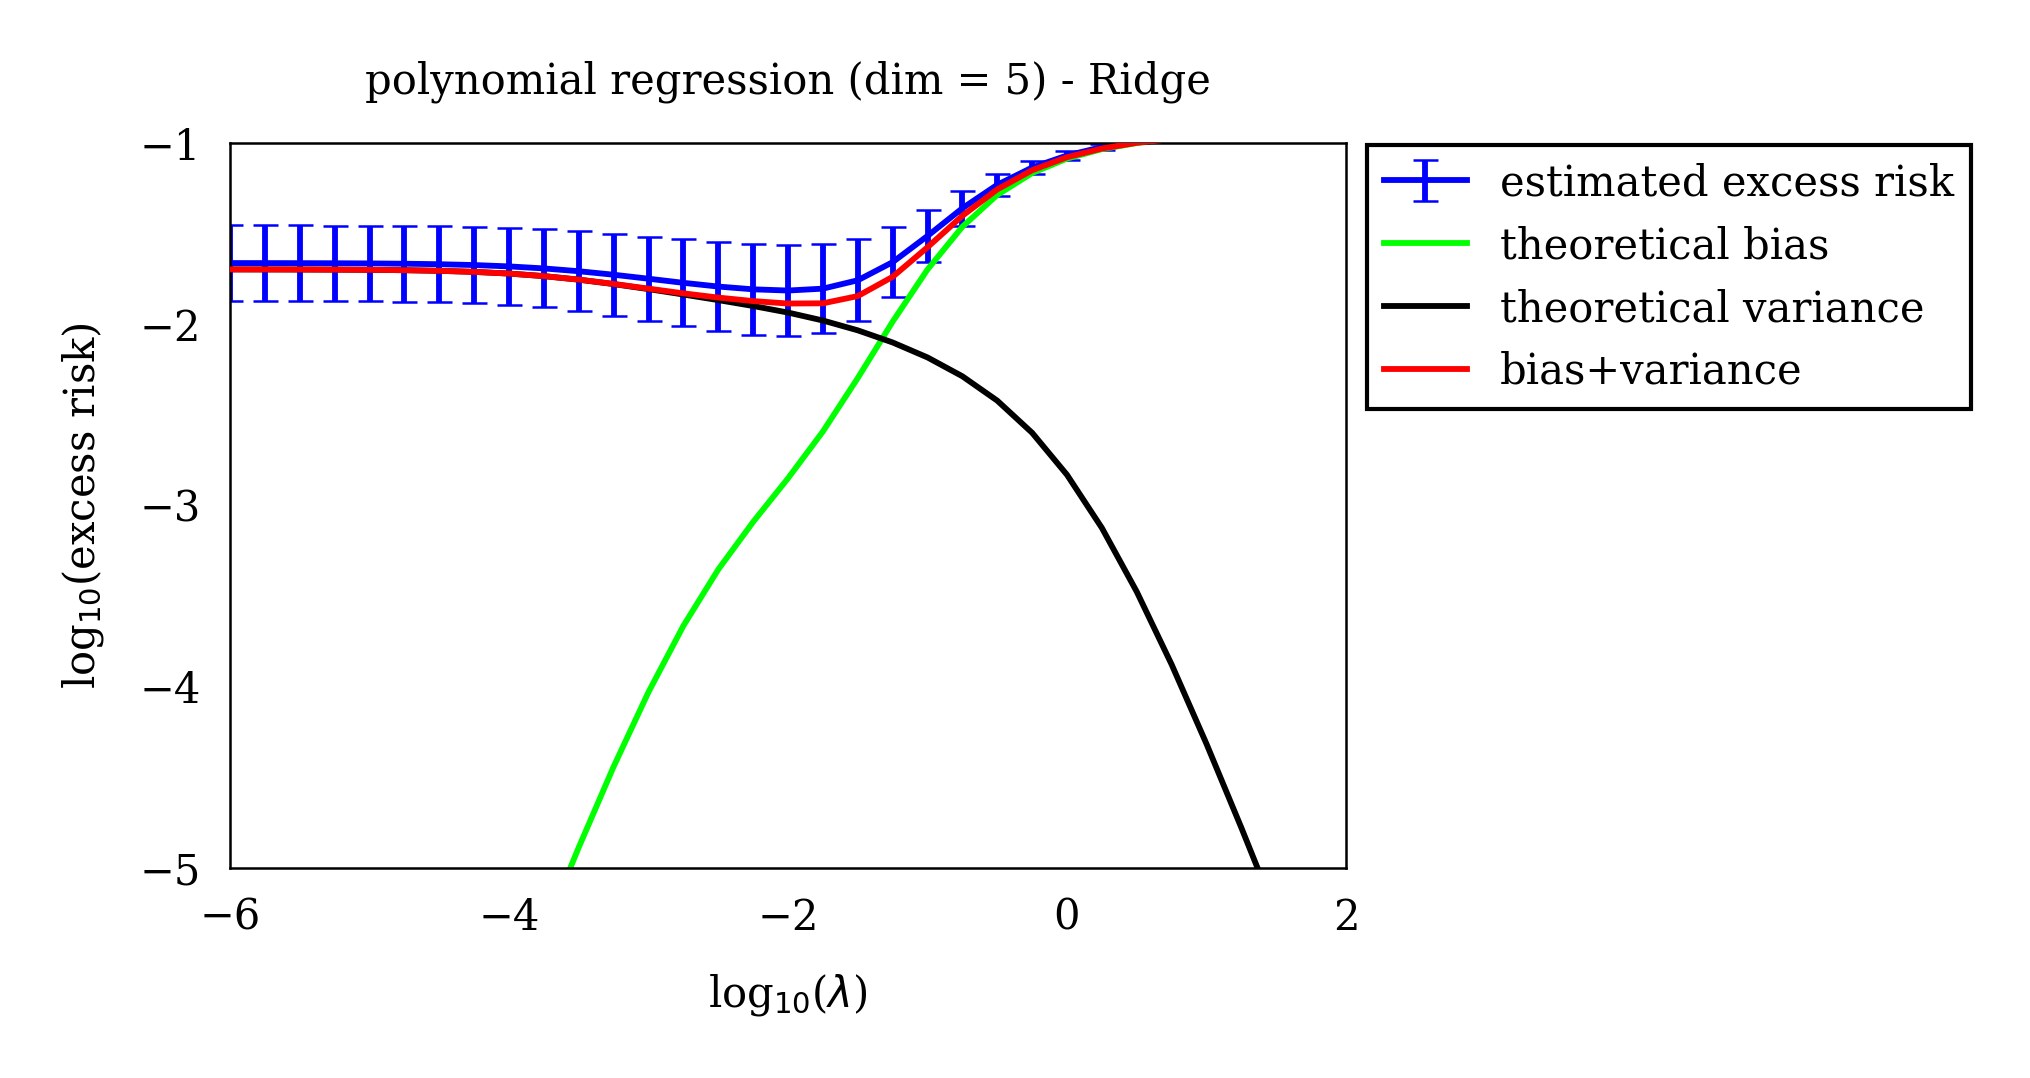

In [ ]:
std_noise = 1
Xgrid = np.arange(-1,1.001, 0.001)
Xgrid = Xgrid[..., None]
n = 300
lambdas = np.array(10**(np.arange(-6, 2.2, 0.25)))
Ygrid = Xgrid**2 - 0.5

Ynoise_rand = randn((Ygrid.shape[0]))
Ygrid_with_noise = Xgrid**2 - 0.5 + Ynoise_rand * std_noise

nrep = 32
# Initialise matrix outside the loop
excess_test_error = np.zeros((32, 33))

for irep in range(1, nrep+1):
    Xsample = np.random.random(n)*2-1
    Ysample = Xsample ** 2 - 0.5 + randn(n) * std_noise
    Xsample = Xsample[..., None]
    kmax = 5
    Xdata = np.ones((n, 1))
    Xgriddata = np.ones((Xgrid.shape[0],1))
    # Horizontal stacking in loop
    for i in range(0, kmax+1):
        if i < kmax:
            Xdata = np.hstack((Xdata, Xsample**(i+1)))
            Xgriddata = np.hstack((Xgriddata, Xgrid**(i+1)))
    # wast calculations
    for ilambda in range(1, len(lambdas)+1):
        lamb = lambdas[ilambda-1]
        matrix1 = np.matmul(np.transpose(Xdata), Xdata) + n * lamb * np.eye(Xdata.shape[1])
        matrix2 = np.matmul(np.transpose(Xdata), Ysample)
        w = np.linalg.solve(matrix1, matrix2)
        Ygrid_prediction = np.matmul(Xgriddata, w)
        excess_test_error[irep-1,ilambda-1] = np.mean(np.power(Ygrid_prediction.reshape(2001,1) - Ygrid,2))

op1 = np.matmul(np.transpose(Xgriddata), Xgriddata)
op2 = np.matmul(np.transpose(Xgriddata), Ygrid)

wast = np.linalg.solve(op1, op2)
bias = lambdas
variance = lambdas
Sigma = np.matmul(np.transpose(Xdata), Xdata)/n

bias = np.zeros((len(lambdas),))
variance = np.zeros((len(lambdas), ))

# Bias and variance calculations
for ilambda in range(0, len(lambdas)):
    lamb = lambdas[ilambda]
    bias1 = lamb**2 * np.transpose(wast)
    bias2 = np.matmul(Sigma, np.linalg.matrix_power(np.linalg.inv(np.matmul(np.transpose(Xdata)
                                                ,Xdata)/n + lamb*np.eye(Xdata.shape[1])), 2))
    bias[ilambda] = np.matmul(np.matmul(bias1, bias2), wast)

    var1 = np.linalg.matrix_power(np.linalg.inv(np.matmul(np.transpose(Xdata), Xdata)/n + lamb*np.eye(Xdata.shape[1])), 2)
    variance[ilambda] = std_noise**2/n * np.trace(np.matmul(np.linalg.matrix_power(Sigma, 2), var1))

# Rename for clarity
x = np.log10(lambdas)
y = np.log10(np.mean(excess_test_error,0))
neg = np.log10(np.mean(excess_test_error,0)+np.std(excess_test_error,0))-np.log10(np.mean(excess_test_error,0))
pos = np.log10(np.mean(excess_test_error,0)+np.std(excess_test_error,0))-np.log10(np.mean(excess_test_error,0))

# Add error bar plot
line4,_,_ = plt.errorbar(x, y, yerr=(neg), color='b', label='estimated excess risk')

# Add Line plots
line1,=plt.plot(np.log10(lambdas), np.log10(bias),'lime', label='theoretical bias')
line2,=plt.plot(np.log10(lambdas), np.log10(variance),'k', label='theoretical variance')
line3,=plt.plot(np.log10(lambdas), np.log10(bias+variance),'r', label='bias+variance', zorder=20)
fig1 = plt.gcf()

# Ticks
plt.gca()
plt.xticks(np.arange(np.min(np.log10(lambdas)), np.max(np.log10(lambdas))+1,step=2))
plt.yticks(np.arange(-5, 0))

# Labels
plt.xlabel(r'log$_{10}$($\lambda$)')
plt.ylabel(r'log$_{10}$(excess risk)')

# Legend
handles, labels = plt.gca().get_legend_handles_labels()
order = [3,0,1,2]
leg = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fancybox=False, bbox_to_anchor=(1, 1.025))
leg.get_frame().set_edgecolor('k')

# Title, axis limits and save figure
plt.title('polynomial regression (dim = 5) - Ridge')
plt.axis([np.min(np.log10(lambdas)), np.max(np.log10(lambdas)), -5, -1])

plt.savefig('fig33.svg')
files.download("fig33.svg")

plt.show()